<!--HEADER-->
*Documentation for the EpiSiming epidemic simulation package*

<!--BADGES-->
<a href="https://colab.research.google.com/github/episiming/epsiming/blob/master/notebooks/01.03-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a><a href="https://mybinder.org/v2/gh/episiming/episiming/master?filepath=notebooks/01.03-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open in Binder"></a><a href="https://nbviewer.jupyter.org/github/episiming/episiming/blob/master/notebooks/01.03-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://raw.githubusercontent.com/episiming/episiming/master/notebooks/01.03-Atributos_de_idade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/download-notebook-9cf" alt="Download Notebook" title="Download Notebook"></a>&nbsp;

<!--NAVIGATOR-->
[<- Construção dos atributos de localização](01.02-Atributos_de_localizacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# Construção do atributo de idade

- Vamos ver, agora, como construir o atributo **idade**.

- A construção deve levar em conta 

    - a **pirâmide etária** da região.

    - restrições quanto à **distribuição etária em função do tamanho da reisidência**.

In [1]:
import datetime

import os, sys

import yaml

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 20/Jul/2020


## Representação dos indivíduos

- Para cada **índice** $i=1, \ldots, N$ representando os indivíduos de uma população de $N$ indivíduos, queremos definir

    - A **idade** $a_i$ do indivíduo $i$.


- Para a definição das **idades**:

    - Usamos a **pirâmide etária** do Rio de Janeiro.
    
    - Usamos certas condições nas idades dependendo do **tamanho da residência** em que habitam.

## Interpolando a pirâmide etária

- Para a definição das idades, precisamos das informações da **pirâmide etária da cidade**.

- Essas pirâmides geralmente não são informadas ano-a-ano, mas em **grupos de idades**.

- Assim, **interpolamos** essa pirâmide em grupos para obter uma pirâmide **ano a ano**.

- Como o último grupo de idades é "aberto a direita", ou seja, não é de um ano a outro, mas, sim, a partir de um determinado ano, precisamos delimitar com uma **idade máxima**.

In [5]:
def get_age_fractions(age_groups, age_group_fractions, age_max=100, interp='linear'):
    '''
    Interpolates the population pyramid.
    
    Population pyramids are usually available in group ages, gathering
    a number of years in each group. This function reads the group ages,
    their population fractions and a maximum desired age and interpolates 
    the data to output a pyramid with data for every year.
    
    The interpolation can be either 'constant' by parts or 'linear' by parts.
    
    Input:
    ------
        age_groups: list of int
            Each element of the list indicates the first age year in the group.
            
        age_group_fractions: list of float
            Each element i of the list is expected to be a float 
            between 0 and 1, indicating the faction of the population
            in the age group from age_groups[i] to age_groups[i+1], if
            i is not the last index, or from age_groups[i] to age_max, 
            if i is the last index
            
        age_max: int
            The maximum age for the output pyramid
            
        interp: str
            The type of interpolation, which can be either piecewise 
            'constant' (default) or piecewise 'linear'.
    
    Output:
    -------
        age_fractions: list of float
            Each element age_fractions[i] of the list indicates the
            fraction of the population at age i.
    '''
    
    # interpola/extrapola pirâmide populacional
    age_fractions = list()
    
    if interp == 'linear':
        for j in range(len(age_groups)-1):
            age_fractions += (age_groups[j+1] - age_groups[j]) \
                * [age_group_fractions[j]/(age_groups[j+1]-age_groups[j])]
        age_fractions += (age_max - age_groups[-1]) \
            * [age_group_fractions[-1]/(age_max-age_groups[-1])]
    elif interp == 'constant':
        for j in range(len(age_groups)-1):
            age_fractions += (age_groups[j+1] - age_groups[j]) \
                * [age_group_fractions[j]/(age_groups[j+1]-age_groups[j])]
        age_fractions += (age_max - age_groups[-1]) \
            * [age_group_fractions[-1]/(age_max-age_groups[-1])]
    else:
        raise ValueError("Argument 'interp' should be either 'linear' or 'constant'.")
    
#    age_fractions = np.array(age_fractions)

    return age_fractions

In [6]:
population_pyramid_file \
    = os.path.join('..',
                   'input',
                   'dados_rio',
                   'piramide_etaria_MRJ.csv')

population_pyramid = pd.read_csv(population_pyramid_file)

population_pyramid

,total,0,1,2,3,4,5,6,7,8,...,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 a 84,85 a 89,90 a 94,95 a 99,100
0,6320446,72828,72657,71632,72365,74550,77218,76536,77789,78054,...,349675,279122,206203,170853,129430,90230,43786,16205,4259,763


In [7]:
age_groups = np.array([int(p[0:3])
                       for p in population_pyramid.columns[1:]])

age_group_fractions \
    = population_pyramid.iloc[0][1:].values/population_pyramid.iloc[0][0]

age_max = 110

age_fractions \
    = get_age_fractions(age_groups,
                        age_group_fractions,
                        age_max
                       )

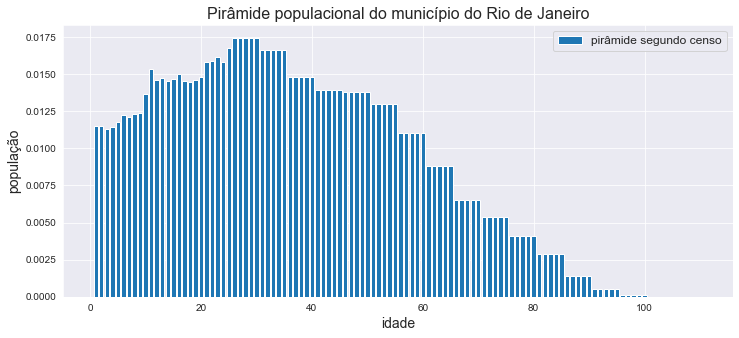

In [8]:
plt.figure(figsize=(12,5))
#plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
#plt.step(list(range(1, age_max+1)), age_fractions, label='pirâmide segundo censo')
plt.bar(list(range(1, age_max+1)), age_fractions, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional do município do Rio de Janeiro', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [24]:
rio = episiming.scenes.RiodeJaneiro(1/1)

In [30]:
%%time
res = (len(rio.res_sizes_dens) +1)*[[]]
for j in range(1,len(rio.res_sizes_dens)+1):
    # seleciona residências com j indivíduos (res[0]=[])
    res[j] = [r for r in rio.res_pop if len(r) == j]

CPU times: user 2.04 s, sys: 44.4 ms, total: 2.09 s
Wall time: 2.19 s


In [32]:
res[2][:10]

[[5, 6],
 [29, 30],
 [36, 37],
 [69, 70],
 [75, 76],
 [77, 78],
 [79, 80],
 [97, 98],
 [150, 151],
 [231, 232]]

In [ ]:
%%time
res = (len(rio.res_sizes_dens) +1)*[[]]
for j in range(1,len(rio.res_sizes_dens)+1):
    # seleciona residências com j indivíduos (res[0]=[])
    res[j] = [r for r in rio.res_pop if len(r) == j]

In [28]:
rio.res_tam[:10]

[4, 1, 2, 4, 4, 4, 7, 3, 2, 1]

In [29]:
rio.res_pop[:10]

[[0, 1, 2, 3],
 [4],
 [5, 6],
 [7, 8, 9, 10],
 [11, 12, 13, 14],
 [15, 16, 17, 18],
 [19, 20, 21, 22, 23, 24, 25],
 [26, 27, 28],
 [29, 30],
 [31]]

In [10]:
def gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes):

    # separa as residências por tamanho
    res = (num_tam_res+1)*[[]]
    for j in range(1,num_tam_res+1):
        # seleciona residências com j indivíduos (res[0]=[])
        res[j] = [r for r in res_individuos if len(r) == j]
    # separa as residências com um adulto e um menor:
    res_2b = random.sample(res[2], k=int(0.1*len(res[2])))
    # separa as residências com dois adultos:
    res_2a = [r for r in res[2] if r not in res_2b]
    # agrega as residências com três ou mais indivíduos:
    res_3mais = []
    for res_k in res[3:]:
        res_3mais += res_k

    # separa a pirâmide populacional
    idades = list(range(len(idades_fracoes)))

    distrib_idades_adultos = num_pop*idades_fracoes
    distrib_idades_adultos[:20] = 0

    distrib_idades_menores = num_pop*idades_fracoes
    distrib_idades_menores[20:] = 0

    # inicializa lista de idades
    pop_idades = np.zeros(num_pop).astype(int)

    # define a idade dos adultos morando sozinhos
    ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res[1]))
    for j in range(len(res[1])):
        pop_idades[res[1][j]] = ind_idades[j]
        distrib_idades_adultos[ind_idades[j]] -= 1

    # define a idade do único adulto em residências com um adulto e um menor
    ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res_2b))
    for j in range(len(res_2b)):
        pop_idades[res_2b[j][0]] = ind_idades[j]
        distrib_idades_adultos[ind_idades[j]] -= 1

    # define a idade de dois adultos nas outras residências com dois 
    # indivíduos
    len_res_2a = len(res_2a)
    ind_idades = random.choices(idades, distrib_idades_adultos,
                                k=2*len_res_2a)
    for j in range(len_res_2a):
        pop_idades[res_2a[j][0]] = ind_idades[j]
        pop_idades[res_2a[j][1]] = ind_idades[len_res_2a + j]
        distrib_idades_adultos[ind_idades[j]] -= 1
        distrib_idades_adultos[ind_idades[len_res_2a + j]] -= 1

    # define a idade de dois adultos nas residências com três ou mais 
    # indivíduos
    len_res_3mais = len(res_3mais)
    ind_idades = random.choices(idades, distrib_idades_adultos,
                                k=2*len_res_3mais)
    for j in range(len_res_3mais):
        pop_idades[res_3mais[j][0]] = ind_idades[j]
        pop_idades[res_3mais[j][1]] = ind_idades[len_res_3mais + j]
        distrib_idades_adultos[ind_idades[j]] -= 1
        distrib_idades_adultos[ind_idades[len_res_3mais + j]] -= 1

    # define a idade dos menores de idade em residências com um adulto 
    # e um menor
    len_res_2b = len(res_2b)
    ind_idades = random.choices(idades, distrib_idades_menores, k=len_res_2b)
    for j in range(len_res_2b):
        pop_idades[res_2b[j][1]] = ind_idades[j]
        distrib_idades_menores[ind_idades[j]] -= 1
    
    # calcula a distribuição restante de idades
    distrib_idades_left = np.array(
        [distrib_idades_menores[j] + distrib_idades_adultos[j] 
        for j in range(len(idades_fracoes))]
        )

    # define a idade do restante dos invidívuos em residências de três 
    # ou mais indivíduos
    for k in range(3,num_tam_res+1):
        ind_idades = random.choices(idades, distrib_idades_left,
                                    k=(k-2)*len(res[k]))
        for j in range(len(res[k])):
            for l in range(2, k):
                pop_idades[res[k][j][l]] = ind_idades[(l-2)*len(res[k]) + j]
                distrib_idades_left[ind_idades[(l-2)*len(res[k]) + j]] -= 1

    return pop_idades

In [20]:
self.pop_idades = gera_idades(
    rio.num_pop, len(rio.res_sizes_dens),
    rio.res_pop, age_fractions)

TypeError: can only assign an iterable

CPU times: user 2.89 ms, sys: 47 µs, total: 2.94 ms
Wall time: 3.3 ms


## Referências

- [DeGroot MH, Schervish MJ (2012), Probability and Statistics, 4th edition, Pearson Education, Inc.](https://www.pearson.com/us/higher-education/program/De-Groot-Probability-and-Statistics-4th-Edition/PGM146802.html).

<!--NAVIGATOR-->

---
[<- Construção dos atributos de localização](01.02-Atributos_de_localizacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 